In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

NOTE : If we dont' clean the data and feed them to an ML system, it basically means we are throwing in a lot of garbage data to the ML system. If we give it garbage, it will give us garbage back. So it's utmost important to clean the data before proceeding.

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

# not taking into consideration those reviews with Score=3 and limiting the data for less computationl power.
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 25000""", con)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')

#changing reviews with score less than 3 to be 0 and greater than 3 to be 1.
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#the shape of the dataset
print('The shape of the dataset before deduplication',filtered_data.shape)

The shape of the dataset before deduplication (25000, 12)


In [3]:
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

The number of positive and negative reviews before the removal of duplicate data.
Positive    20913
Negative     4087
Name: SentimentPolarity, dtype: int64


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=\
filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries, removing where UserId","ProfileName","Time","Text" are same but keeping the first entry.
filtered_duplicates=\
filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [6]:
#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

In [7]:
#shape of the dataset after deduplication
print("The shape of the dataset after deduplication", final.shape)

The shape of the dataset after deduplication (23953, 12)


In [8]:
print("The number of positive and negative reviews after deduplication.")
print(final["SentimentPolarity"].value_counts())

The number of positive and negative reviews after deduplication.
Positive    20071
Negative     3882
Name: SentimentPolarity, dtype: int64


In [9]:
#Checking to see how much % of data still remains
(final['Id'].shape[0]*1.0)/(filtered_data['Id'].shape[0]*1.0)*100

95.812

In [10]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1


# Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
stopwords= set(['br','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

<h2><font color='black'> Preprocess Reviews</font></h2>

In [13]:
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
    sentence = re.sub(r"http\S+", "", sentence)
    #remove html tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # removing the words from the stop words
    sentance = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████████████████████████████████████████████████████████████████████| 23953/23953 [00:15<00:00, 1521.29it/s]


In [14]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews 

In [15]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0,Product arrived labeled as Jumbo Salted Peanut...


Text(0.5, 1.0, 'Positive Reviews vs Negative Reviews')

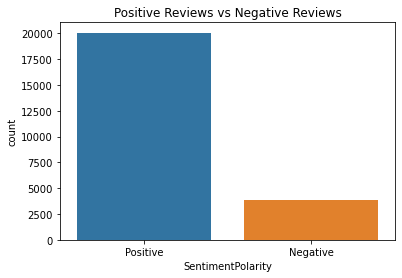

In [16]:
#Display distribution of Postive and Negative reviews in a bar graph
sns.countplot(data=final, x='SentimentPolarity').set_title("Positive Reviews vs Negative Reviews")

Text(0.5, 1.0, 'pdf for length of reviews')

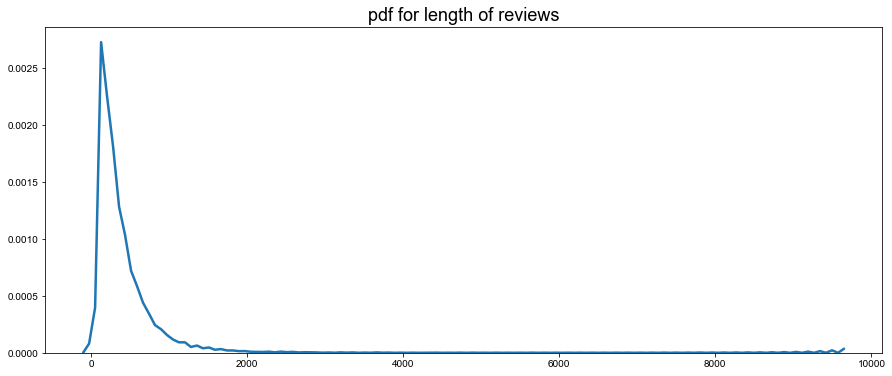

In [17]:
#length of text of each review
length=list(final['CleanedText'].apply(lambda x: len(x)))

plt.subplots(figsize=(15,6))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.color_palette('dark')

#pdf of reviews
sns.distplot(length,hist=False).set_title('pdf for length of reviews')

# Observation:
Length of reviews follows power law distribution which implies 80% of data lies in first 20% region.

In [18]:
#converting time stamp to date and column as data
final['date'] = pd.to_datetime(final['Time'], unit='s')
final['date']

0       2011-04-27
1       2012-09-07
2       2008-08-18
3       2011-06-13
4       2012-10-21
           ...    
24995   2012-02-29
24996   2012-05-09
24997   2010-01-31
24998   2010-02-05
24999   2012-03-01
Name: date, Length: 23953, dtype: datetime64[ns]

Text(0.5, 1.0, 'Reviews by users each year')

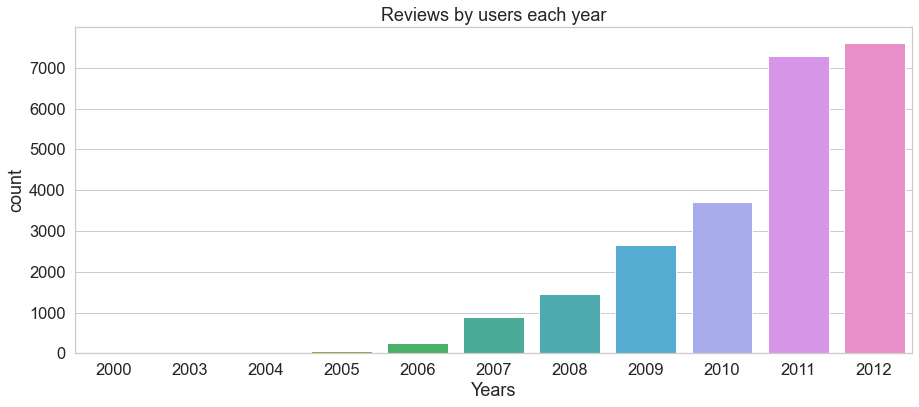

In [19]:
plt.subplots(figsize=(15,6))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.color_palette('dark')

years=final['date'].map(lambda x:x.year).reset_index()
years.columns=['Counts','Years']

sns.countplot(data=years,x='Years').set_title('Reviews by users each year')

# Observations:
Year 2012 has the most number of reviews.
Number of reviews are increasing each year.

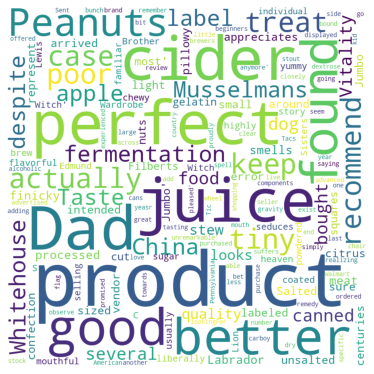

In [20]:

#https://www.geeksforgeeks.org/generating-word-cloud-python/
#Word Cloud is a data visualization technique used for representing text data 
#in which the size of each word indicates its frequency or importance.

from wordcloud import WordCloud
comment_words = str(final["CleanedText"].values) 

wordcloud = WordCloud(width = 800, height = 800,background_color ='white',\
                      min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

                                      ProfileName  Id
0               ! MR. KNOW IT ALL  ;-b "DR SHOCK"   3
1                                   #1 Amazon Fan   1
2                                          #1aunt   1
3                                  &#34;Ally&#34;   1
4               '  Groovin' guy "music historian"   8
...                                           ...  ..
20425                       ~ Charliann Roberts ~   1
20426  ~*Just Me *~ "I Hope My Reviews Help You!"   1
20427                                        ~Ant   1
20428                                    ~Kimber~   1
20429                                         ~mo   1

[20430 rows x 2 columns]
                                  ProfileName  Id
17631                                      c2  21
3076                                    Chris  20
5645                            Gary Peterson  17
2285                         C. F. Hill "CFH"  15
7959                                     John  14
7741                      

Text(0.5, 1.0, 'Reviews by user')

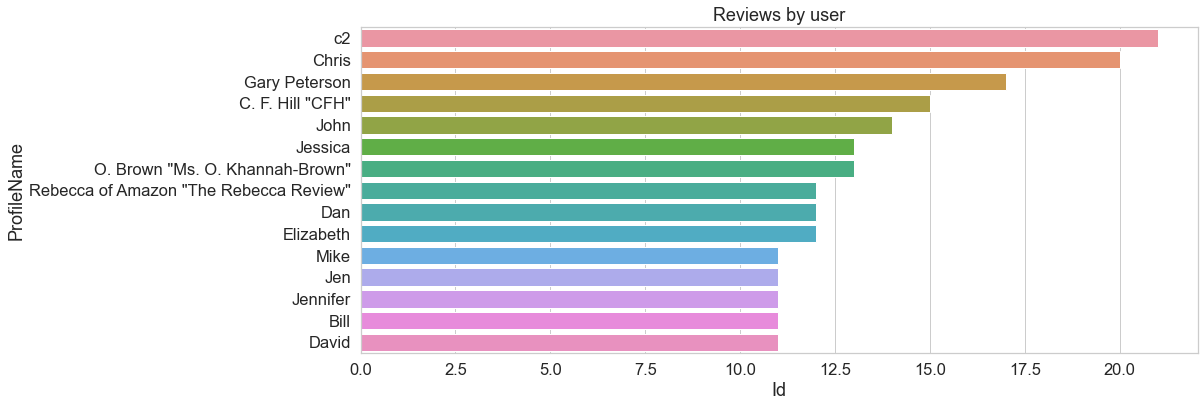

In [21]:
#top users
top= final.groupby(by='ProfileName')['Id'].count().reset_index()
print(top)
top=top.sort_values('Id',ascending=False)[:15]
print(top)

plt.subplots(figsize=(15,6))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.color_palette('dark')

sns.barplot(data=top,x='Id',y='ProfileName').set_title('Reviews by user')

In [22]:
X=final['CleanedText'] #taking only reviews as feature
y=final['Class_Labels']
print("The shape of the data", X.shape, y.shape)

The shape of the data (23953,) (23953,)


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("The shape of X_train and y_train", X_train.shape, y_train.shape)
print("The shape of X_test and y_test", X_test.shape, y_test.shape)

The shape of X_train and y_train (16048,) (16048,)
The shape of X_test and y_test (7905,) (7905,)


# Featurization

## Encoding Reviews Text using BAG OF WORDS

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer() #in scikit-learn
vect.fit(X_train)

X_train_bow=vect.transform(X_train)
X_test_bow=vect.transform(X_test)

print("The shape of X_train and y_train after vectorization", X_train_bow.shape, y_train.shape)
print("The shape of X_test and y_test after vectorization", X_test_bow.shape, y_test.shape)

The shape of X_train and y_train after vectorization (16048, 23985) (16048,)
The shape of X_test and y_test after vectorization (7905, 23985) (7905,)


# Hyperparameter Tunning on Logistics Regression.

In [25]:
#https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(class_weight='balanced', random_state=1, n_jobs=-1)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', return_train_score=True)
grid_result = grid_search.fit(X_train_bow, y_train)
# summarize results
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))

Best: 0.9256068428723166 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.8944447116745382 (0.01088353661994347) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.8956093424589557 (0.010963217401651279) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8944463204784628 (0.010889674822732197) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.9036770453436652 (0.010313870707857557) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.9029451917696573 (0.01008961979995424) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9036708750085308 (0.010311157675829883) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.9161363387827401 (0.009566414779255437) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.9151511977442588 (0.009207033486293006) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.916135199568761 (0.009564642746880575) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.9256068428723166 (0.00926756413753048) with

In [26]:
#creating dataframe of the result received from gridsearchcv
results=pd.DataFrame.from_dict(grid_result.cv_results_)
results = results.sort_values(['param_C'])
results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,...,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
12,3.486455,0.264439,0.005562,0.003021,0.01,l2,newton-cg,"{'C': 0.01, 'penalty': 'l2', 'solver': 'newton...",0.918979,0.920291,...,0.955931,0.955812,0.956232,0.956663,0.956558,0.956044,0.955841,0.956133,0.956273,0.000465
13,2.302908,0.271255,0.003905,0.002679,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.918979,0.920291,...,0.955931,0.955814,0.956230,0.956662,0.956557,0.956043,0.955841,0.956132,0.956273,0.000464


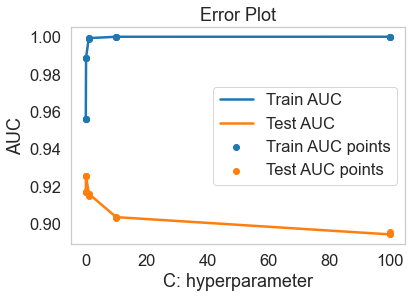

In [27]:
#plotting hyperparameter C vs train and test AUC Score
train_auc= results['mean_train_score']
test_auc = results['mean_test_score'] 

C =  results['param_C']

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, test_auc, label='Test AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, test_auc, label='Test AUC points')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Error Plot")
plt.grid()
plt.show()

In [28]:
Opt_bow_C=grid_result.best_estimator_.C
print('The optimal value of C using bag of words feature encoding',Opt_bow_C)

The optimal value of C using bag of words feature encoding 0.1


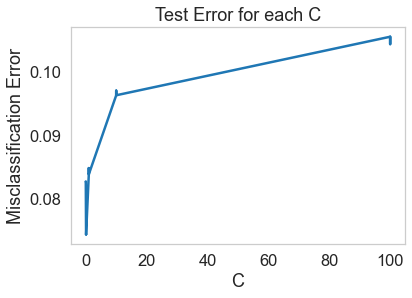

In [29]:
#ploting errors and test scores
MSE=1-results['mean_test_score'] 

plt.plot(C, MSE)
plt.grid()
plt.title("Test Error for each C")
plt.xlabel("C")
plt.ylabel("Misclassification Error")
plt.show()

In [31]:
# training the model with the optimal C value 
from sklearn.metrics import roc_curve, auc

model = LogisticRegression(C=Opt_bow_C, class_weight='balanced', random_state=1, n_jobs=-1)
clf=model.fit(X_train_bow,y_train)

#predict_proba gives probability score
y_train_pred = clf.predict_proba(X_train_bow)[:,1]    
y_test_pred=clf.predict_proba(X_test_bow)[:,1]

#getting TPF, FPR to plot ROC curve
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

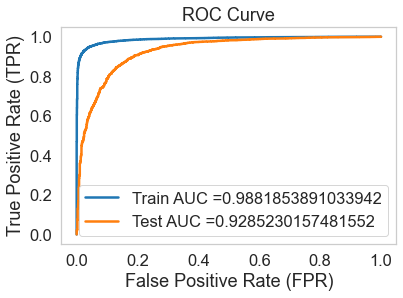

In [32]:
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [33]:
# calculating the f1 score of models
from sklearn.metrics import f1_score

y_test_pred_bow = clf.predict(X_test_bow)
f1_score_bow=f1_score(y_test, y_test_pred_bow)
print("f1 Score is ", f1_score_bow)

f1 Score is  0.9350007719623282


Test confusion matrix


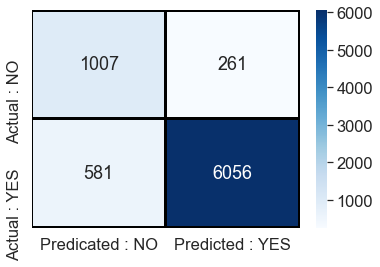

In [34]:
#plotting confusion matrix using seaborn
from sklearn.metrics import confusion_matrix

print("Test confusion matrix")
sns.heatmap(confusion_matrix(y_test,y_test_pred_bow),annot=True, fmt='d', cmap='Blues', linewidth=2, \
                             linecolor='black', xticklabels=['Predicated : NO', 'Predicted : YES'],\
           yticklabels=['Actual : NO', 'Actual : YES'])

# Encoding Reviews Text using TFIDF

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(ngram_range=(1,1))
tfidf = vect.fit(X_train.values)

X_train_tfidf=vect.transform(X_train)
X_test_tfidf=vect.transform(X_test)

print("The shape of X_train and y_train after vectorization", X_train_tfidf.shape, y_train.shape)
print("The shape of X_test and y_test after vectorization", X_test_tfidf.shape, y_test.shape)

The shape of X_train and y_train after vectorization (16048, 23985) (16048,)
The shape of X_test and y_test after vectorization (7905, 23985) (7905,)


# Hyperparameter Tunning on Logistics Regression

In [36]:
#https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(class_weight='balanced', random_state=1, n_jobs=-1)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', return_train_score=True)
grid_result = grid_search.fit(X_train_tfidf, y_train)
# summarize results
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format (mean, stdev, param))

Best: 0.941379457893125 using {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9267768016655284 (0.00639087170735401) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.9269371512641527 (0.006445684214123698) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9267767060191496 (0.006394884037448361) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.9391902729609851 (0.005663116644438916) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.9391847593101873 (0.0056567975770493665) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9391925517151765 (0.005662796339550789) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.9413786040654323 (0.005953135315181297) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.941379457893125 (0.00595593546162019) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9413783175378689 (0.005953422965044106) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.9177002042899056 (0.00740770783800211) with: {'

In [37]:
#creating dataframe of the output received from gridsearchcv
results=pd.DataFrame.from_dict(grid_result.cv_results_)
results = results.sort_values(['param_C'])
results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,...,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
12,0.763003,0.033546,0.003036,0.001751,0.01,l2,newton-cg,"{'C': 0.01, 'penalty': 'l2', 'solver': 'newton...",0.890719,0.895413,...,0.904883,0.904161,0.904201,0.905218,0.901815,0.902176,0.902428,0.903712,0.903626,0.001118
13,0.365571,0.048884,0.003797,0.002024,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.890722,0.895404,...,0.904884,0.904161,0.904203,0.905218,0.901817,0.902177,0.902429,0.903712,0.903627,0.001118


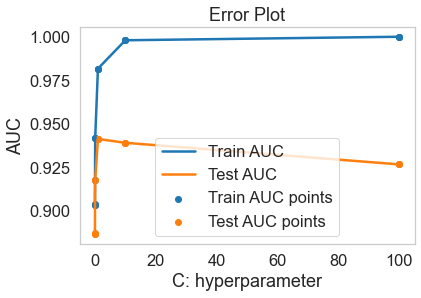

In [38]:
#plotting hyperparameter C vs train and test AUC 

train_auc= results['mean_train_score']
test_auc = results['mean_test_score'] 

C =  results['param_C']

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, test_auc, label='Test AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, test_auc, label='Test AUC points')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Error Plot")
plt.grid()
plt.show()

In [39]:
Opt_tfidf_C=grid_result.best_estimator_.C
print('The optimal value of C using Tfidf feature encoding',Opt_tfidf_C)

The optimal value of C using Tfidf feature encoding 1.0


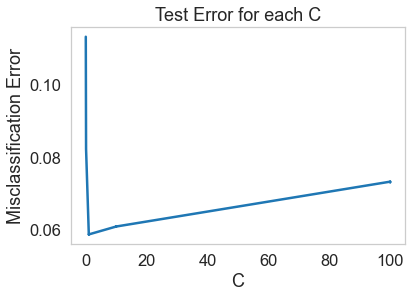

In [40]:
#ploting errors and test scores
MSE=1-results['mean_test_score'] 

plt.plot(C, MSE)
plt.grid()
plt.title("Test Error for each C")
plt.xlabel("C")
plt.ylabel("Misclassification Error")
plt.show()

In [41]:
# training the model with the optimal C value 
from sklearn.metrics import roc_curve, auc

model = LogisticRegression(C=Opt_tfidf_C, class_weight='balanced', random_state=1, n_jobs=-1)
clf=model.fit(X_train_tfidf,y_train)

y_train_pred = clf.predict_proba(X_train_tfidf)[:,1]    
y_test_pred=clf.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

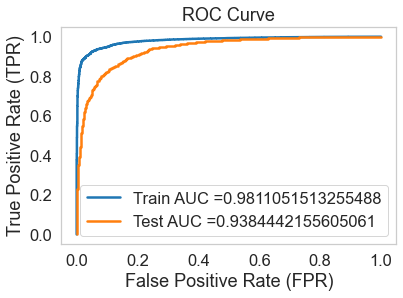

In [42]:
#plotting TPR vs FPR i.e. ROC curve 

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [43]:
# calculating the f1 score of models
from sklearn.metrics import f1_score

y_test_pred_tfidf = clf.predict(X_test_tfidf)
f1_score_tfidf=f1_score(y_test, y_test_pred_tfidf)
print("f1 Score is ", f1_score_tfidf)

f1 Score is  0.9265235782547392


Test confusion matrix


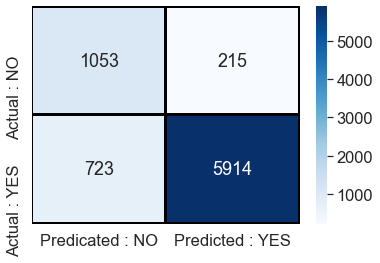

In [44]:
#plotting confusion matrix using seaborn
from sklearn.metrics import confusion_matrix

print("Test confusion matrix")
sns.heatmap(confusion_matrix(y_test,y_test_pred_tfidf),annot=True, fmt='d', cmap='Blues', linewidth=2, \
                             linecolor='black', xticklabels=['Predicated : NO', 'Predicted : YES'],\
           yticklabels=['Actual : NO', 'Actual : YES'])

In [45]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
from sklearn.metrics import roc_auc_score

x = PrettyTable()

x.field_names = ['Vectorizer', 'Model', 'Hyperparameters', 'F1 Score']

x.add_row(['BOW','Logistics Regression',Opt_bow_C, f1_score_bow])
x.add_row(['TFIDF ','Logistics Regression',Opt_tfidf_C, f1_score_tfidf])

print(x)

+------------+----------------------+-----------------+--------------------+
| Vectorizer |        Model         | Hyperparameters |      F1 Score      |
+------------+----------------------+-----------------+--------------------+
|    BOW     | Logistics Regression |       0.1       | 0.9350007719623282 |
|   TFIDF    | Logistics Regression |       1.0       | 0.9265235782547392 |
+------------+----------------------+-----------------+--------------------+
